# Extract Data from yfinance

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:

df = yf.download('TSLA', 
                  start='2019-01-01', 
                  end='2024-4-29', 
                  progress=False)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-22,140.559998,144.440002,138.800003,142.050003,142.050003,107097600
2024-04-23,143.330002,147.259995,141.110001,144.679993,144.679993,124545100
2024-04-24,162.839996,167.970001,157.509995,162.130005,162.130005,181178000
2024-04-25,158.960007,170.880005,158.360001,170.179993,170.179993,126427500
2024-04-26,168.850006,172.119995,166.369995,168.289993,168.289993,109815700


In [3]:
df['Date'] = df.index  # Create a new column 'Date' with the index values
df.reset_index(drop=True, inplace=True) 

In [4]:
close_df = df[['Date', 'Close']]

In [5]:
close_df.head()

,Date,Close
0,2019-01-02,20.674667
1,2019-01-03,20.024000
2,2019-01-04,21.179333
3,2019-01-07,22.330667
4,2019-01-08,22.356667


In [6]:
close_df_copy = close_df.copy()
close_df_copy = close_df_copy.drop('Date', axis = 1)

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

scaler = scaler.fit(close_df_copy)
close_df_copy_scaled = scaler.transform(close_df_copy)

# Create a Window Function

In [8]:
X, y = [], []

window_size = 30
target = 1
for i in range(window_size, len(close_df_copy_scaled) - target + 1):
    X.append(close_df_copy_scaled[i - window_size: i, :])
    y.append(close_df_copy_scaled[i + target - 1:i + target, 0])
    
X, y = np.array(X), np.array(y)

In [9]:
print(X.shape, y.shape)

(1309, 30, 1) (1309, 1)


In [10]:
training_size=int(len(y)*0.8)
X_train, X_test = X[:training_size], X[training_size:]
y_train, y_test = y[:training_size], y[training_size:]

In [11]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1047, 30, 1) (262, 30, 1) (1047, 1) (262, 1)


In [12]:
def mse(preds, targets):
    return F.mse_loss(preds, targets)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(actual, forecast):
    
    if len(actual) != len(forecast):
        raise ValueError("Length of actual and forecast lists must be the same")
    
    absolute_errors = [abs(actual[i] - forecast[i]) for i in range(len(actual))]
    percentage_errors = [absolute_errors[i] / actual[i] * 100 for i in range(len(actual))]
    mape = sum(percentage_errors) / len(actual)
    
    return mape


In [13]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0, attention_axes=None):
 
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

def build_transfromer(head_size, 
                      num_heads,
                      ff_dim,
                      num_trans_blocks,
                      mlp_units, dropout=0, mlp_dropout=0) -> tf.keras.Model:

  n_timesteps, n_features, n_outputs = window_size, 1, 1
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs 
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
  
  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs, activation='relu')(x)
  return tf.keras.Model(inputs, outputs)


In [14]:
import optuna
def objective(trial):
    
    
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.002)
    num_heads = trial.suggest_categorical('n_heads', [8,16, 24])
    head_size = trial.suggest_categorical('head_size', [128, 256, 512])
    ff_dim = trial.suggest_categorical('ff_dim', [2, 4, 8])
    
    print('Learning Rate', learning_rate)
    print('num_heads', num_heads)
    print('head_size', head_size)
    print('head_size', ff_dim)
    
    model = build_transfromer(head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, 
                              num_trans_blocks=4, mlp_units=[256], 
                              mlp_dropout=0.10, dropout=0.2)
    
    checkpoint = ModelCheckpoint(f'tesla_model_transformer/model_tesla_window_30_{learning_rate}.h5', save_best_only=True)
    model.compile(loss='mean_squared_error',optimizer= Adam(learning_rate=learning_rate))
    model.fit(X_train, y_train, batch_size=32,epochs=400, validation_data=(X_test, y_test), verbose=1, callbacks=[checkpoint])

    model_load = load_model(f'tesla_model_transformer/model_tesla_window_30_{learning_rate}.h5')
    test_predictions = model_load.predict(X_test)
    test_predictions = scaler.inverse_transform(test_predictions)
        
    y_test1 = scaler.inverse_transform(y_test)
        
    y_TEST = y_test1
    y_PRED = test_predictions
        
    #mae = mean_absolute_error(y_TEST[-256:], y_PRED[-256:])
    #RMSE = rmse(y_TEST[-256:], y_PRED[-256:])
    MAPE = calculate_mape(y_TEST[-256:], y_PRED[-256:])
    #r2 = r2_score(y_TEST[-256:], y_PRED[-256:])
    
    return MAPE

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 20)

trial = study.best_trial
print(trial)

[I 2024-05-13 18:50:02,027] A new study created in memory with name: no-name-4a7b7b05-8442-4f33-8df0-43e25897faa6


Learning Rate 0.0019745514796305342
num_heads 16
head_size 256
head_size 8
Epoch 1/400
33/33 [==============================] - 9s 53ms/step - loss: 0.0322 - val_loss: 0.0032
Epoch 2/400
33/33 [==============================] - 1s 36ms/step - loss: 0.0054 - val_loss: 0.0019
Epoch 3/400
33/33 [==============================] - 1s 31ms/step - loss: 0.0042 - val_loss: 0.0030
Epoch 4/400
33/33 [==============================] - 1s 31ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 5/400
33/33 [==============================] - 1s 32ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 6/400
33/33 [==============================] - 1s 36ms/step - loss: 0.0029 - val_loss: 7.8713e-04
Epoch 7/400
33/33 [==============================] - 1s 32ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 8/400
33/33 [==============================] - 1s 30ms/step - loss: 0.0023 - val_loss: 8.0794e-04
Epoch 9/400
33/33 [==============================] - 1s 31ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 10/400
33/3

[I 2024-05-13 18:57:43,934] Trial 0 finished with value: 2.336205560495759 and parameters: {'learning_rate': 0.0019745514796305342, 'n_heads': 16, 'head_size': 256, 'ff_dim': 8}. Best is trial 0 with value: 2.336205560495759.


Learning Rate 0.001285669341455549
num_heads 24
head_size 512
head_size 4
Epoch 1/400
33/33 [==============================] - 6s 91ms/step - loss: 0.0679 - val_loss: 0.0064
Epoch 2/400
33/33 [==============================] - 2s 74ms/step - loss: 0.0073 - val_loss: 0.0012
Epoch 3/400
33/33 [==============================] - 2s 75ms/step - loss: 0.0044 - val_loss: 6.9462e-04
Epoch 4/400
33/33 [==============================] - 2s 72ms/step - loss: 0.0038 - val_loss: 8.6705e-04
Epoch 5/400
33/33 [==============================] - 2s 75ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 6/400
33/33 [==============================] - 3s 79ms/step - loss: 0.0034 - val_loss: 5.9730e-04
Epoch 7/400
33/33 [==============================] - 3s 77ms/step - loss: 0.0030 - val_loss: 5.5718e-04
Epoch 8/400
33/33 [==============================] - 2s 76ms/step - loss: 0.0033 - val_loss: 5.3710e-04
Epoch 9/400
33/33 [==============================] - 2s 71ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 

[I 2024-05-13 19:15:39,435] Trial 1 finished with value: 2.3622430901006863 and parameters: {'learning_rate': 0.001285669341455549, 'n_heads': 24, 'head_size': 512, 'ff_dim': 4}. Best is trial 0 with value: 2.336205560495759.


Learning Rate 0.00029853183231735213
num_heads 24
head_size 512
head_size 2
Epoch 1/400
33/33 [==============================] - 7s 99ms/step - loss: 0.1971 - val_loss: 0.1830
Epoch 2/400
33/33 [==============================] - 3s 86ms/step - loss: 0.1309 - val_loss: 0.1595
Epoch 3/400
33/33 [==============================] - 3s 86ms/step - loss: 0.0860 - val_loss: 0.1501
Epoch 4/400
33/33 [==============================] - 3s 86ms/step - loss: 0.0480 - val_loss: 0.0935
Epoch 5/400
33/33 [==============================] - 3s 86ms/step - loss: 0.0316 - val_loss: 0.0439
Epoch 6/400
33/33 [==============================] - 3s 87ms/step - loss: 0.0191 - val_loss: 0.0119
Epoch 7/400
33/33 [==============================] - 3s 87ms/step - loss: 0.0113 - val_loss: 0.0072
Epoch 8/400
33/33 [==============================] - 3s 87ms/step - loss: 0.0087 - val_loss: 0.0032
Epoch 9/400
33/33 [==============================] - 3s 87ms/step - loss: 0.0072 - val_loss: 0.0024
Epoch 10/400
33/33 [====

[I 2024-05-13 19:34:01,256] Trial 2 finished with value: 2.433812246586196 and parameters: {'learning_rate': 0.00029853183231735213, 'n_heads': 24, 'head_size': 512, 'ff_dim': 2}. Best is trial 0 with value: 2.336205560495759.


Learning Rate 0.0009253545599149688
num_heads 24
head_size 128
head_size 4
Epoch 1/400
33/33 [==============================] - 5s 50ms/step - loss: 0.0344 - val_loss: 0.0029
Epoch 2/400
33/33 [==============================] - 1s 35ms/step - loss: 0.0053 - val_loss: 0.0022
Epoch 3/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0045 - val_loss: 0.0013
Epoch 4/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0037 - val_loss: 8.7999e-04
Epoch 5/400
33/33 [==============================] - 1s 32ms/step - loss: 0.0032 - val_loss: 9.2287e-04
Epoch 6/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0029 - val_loss: 7.8451e-04
Epoch 7/400
33/33 [==============================] - 1s 36ms/step - loss: 0.0027 - val_loss: 7.8069e-04
Epoch 8/400
33/33 [==============================] - 1s 32ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 9/400
33/33 [==============================] - 1s 32ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 10/

[I 2024-05-13 19:41:06,515] Trial 3 finished with value: 2.3790072397320725 and parameters: {'learning_rate': 0.0009253545599149688, 'n_heads': 24, 'head_size': 128, 'ff_dim': 4}. Best is trial 0 with value: 2.336205560495759.


Learning Rate 0.0018978419032399366
num_heads 16
head_size 128
head_size 2
Epoch 1/400
33/33 [==============================] - 5s 49ms/step - loss: 0.1289 - val_loss: 0.0386
Epoch 2/400
33/33 [==============================] - 1s 32ms/step - loss: 0.0212 - val_loss: 0.0236
Epoch 3/400
33/33 [==============================] - 1s 34ms/step - loss: 0.0118 - val_loss: 0.0185
Epoch 4/400
33/33 [==============================] - 1s 35ms/step - loss: 0.0086 - val_loss: 0.0109
Epoch 5/400
33/33 [==============================] - 1s 32ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 6/400
33/33 [==============================] - 1s 35ms/step - loss: 0.0051 - val_loss: 0.0022
Epoch 7/400
33/33 [==============================] - 1s 26ms/step - loss: 0.0048 - val_loss: 0.0030
Epoch 8/400
33/33 [==============================] - 1s 27ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 9/400
33/33 [==============================] - 1s 32ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 10/400
33/33 [=====

[I 2024-05-13 19:47:17,848] Trial 4 finished with value: 2.401984936667241 and parameters: {'learning_rate': 0.0018978419032399366, 'n_heads': 16, 'head_size': 128, 'ff_dim': 2}. Best is trial 0 with value: 2.336205560495759.


Learning Rate 0.0015308200530821212
num_heads 8
head_size 128
head_size 8
Epoch 1/400
33/33 [==============================] - 5s 44ms/step - loss: 0.0390 - val_loss: 0.0062
Epoch 2/400
33/33 [==============================] - 1s 34ms/step - loss: 0.0055 - val_loss: 9.8736e-04
Epoch 3/400
33/33 [==============================] - 1s 36ms/step - loss: 0.0053 - val_loss: 9.2786e-04
Epoch 4/400
33/33 [==============================] - 1s 31ms/step - loss: 0.0039 - val_loss: 7.1035e-04
Epoch 5/400
33/33 [==============================] - 1s 31ms/step - loss: 0.0034 - val_loss: 5.9533e-04
Epoch 6/400
33/33 [==============================] - 1s 27ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 7/400
33/33 [==============================] - 1s 29ms/step - loss: 0.0032 - val_loss: 8.6701e-04
Epoch 8/400
33/33 [==============================] - 1s 23ms/step - loss: 0.0028 - val_loss: 0.0036
Epoch 9/400
33/33 [==============================] - 1s 31ms/step - loss: 0.0029 - val_loss: 5.7502e-04
Ep

[I 2024-05-13 19:53:01,374] Trial 5 finished with value: 2.4453281612517115 and parameters: {'learning_rate': 0.0015308200530821212, 'n_heads': 8, 'head_size': 128, 'ff_dim': 8}. Best is trial 0 with value: 2.336205560495759.


Learning Rate 0.001470437822502643
num_heads 8
head_size 256
head_size 4
Epoch 1/400
33/33 [==============================] - 5s 47ms/step - loss: 0.2257 - val_loss: 0.2801
Epoch 2/400
33/33 [==============================] - 1s 24ms/step - loss: 0.2257 - val_loss: 0.2801
Epoch 3/400
33/33 [==============================] - 1s 24ms/step - loss: 0.2257 - val_loss: 0.2801
Epoch 4/400
33/33 [==============================] - 1s 33ms/step - loss: 0.1413 - val_loss: 0.0038
Epoch 5/400
33/33 [==============================] - 1s 30ms/step - loss: 0.0169 - val_loss: 0.0011
Epoch 6/400
33/33 [==============================] - 1s 26ms/step - loss: 0.0045 - val_loss: 0.0022
Epoch 7/400
33/33 [==============================] - 1s 27ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 8/400
33/33 [==============================] - 1s 32ms/step - loss: 0.0031 - val_loss: 6.7238e-04
Epoch 9/400
33/33 [==============================] - 1s 24ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 10/400
33/33 [===

[I 2024-05-13 19:59:03,251] Trial 6 finished with value: 2.3883706062763497 and parameters: {'learning_rate': 0.001470437822502643, 'n_heads': 8, 'head_size': 256, 'ff_dim': 4}. Best is trial 0 with value: 2.336205560495759.


Learning Rate 0.0018984598313282965
num_heads 8
head_size 512
head_size 8
Epoch 1/400
33/33 [==============================] - 5s 53ms/step - loss: 0.1512 - val_loss: 0.1199
Epoch 2/400
33/33 [==============================] - 1s 38ms/step - loss: 0.0268 - val_loss: 0.0046
Epoch 3/400
33/33 [==============================] - 1s 39ms/step - loss: 0.0130 - val_loss: 0.0030
Epoch 4/400
33/33 [==============================] - 1s 39ms/step - loss: 0.0073 - val_loss: 0.0018
Epoch 5/400
33/33 [==============================] - 1s 33ms/step - loss: 0.0053 - val_loss: 0.0018
Epoch 6/400
33/33 [==============================] - 1s 38ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 7/400
33/33 [==============================] - 1s 33ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 8/400
33/33 [==============================] - 1s 33ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 9/400
33/33 [==============================] - 1s 39ms/step - loss: 0.0030 - val_loss: 8.0102e-04
Epoch 10/400
33/33 [==

[I 2024-05-13 20:06:50,605] Trial 7 finished with value: 2.4227892204772203 and parameters: {'learning_rate': 0.0018984598313282965, 'n_heads': 8, 'head_size': 512, 'ff_dim': 8}. Best is trial 0 with value: 2.336205560495759.


Learning Rate 0.0011151385627639352
num_heads 16
head_size 128
head_size 2
Epoch 1/400
33/33 [==============================] - 5s 49ms/step - loss: 0.0287 - val_loss: 0.0035
Epoch 2/400
33/33 [==============================] - 1s 34ms/step - loss: 0.0061 - val_loss: 0.0014
Epoch 3/400
33/33 [==============================] - 1s 33ms/step - loss: 0.0050 - val_loss: 0.0012
Epoch 4/400
33/33 [==============================] - 1s 32ms/step - loss: 0.0036 - val_loss: 6.9927e-04
Epoch 5/400
33/33 [==============================] - 1s 33ms/step - loss: 0.0034 - val_loss: 6.5142e-04
Epoch 6/400
33/33 [==============================] - 1s 27ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 7/400
33/33 [==============================] - 1s 32ms/step - loss: 0.0027 - val_loss: 6.0621e-04
Epoch 8/400
33/33 [==============================] - 1s 28ms/step - loss: 0.0032 - val_loss: 0.0010
Epoch 9/400
33/33 [==============================] - 1s 31ms/step - loss: 0.0024 - val_loss: 6.4870e-04
Epoch 10/

[I 2024-05-13 20:12:57,545] Trial 8 finished with value: 2.4113580517619315 and parameters: {'learning_rate': 0.0011151385627639352, 'n_heads': 16, 'head_size': 128, 'ff_dim': 2}. Best is trial 0 with value: 2.336205560495759.


Learning Rate 0.0008015105230087288
num_heads 24
head_size 128
head_size 2
Epoch 1/400
33/33 [==============================] - 5s 52ms/step - loss: 0.0249 - val_loss: 0.0061
Epoch 2/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0072 - val_loss: 0.0014
Epoch 3/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0050 - val_loss: 9.0019e-04
Epoch 4/400
33/33 [==============================] - 1s 31ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 5/400
33/33 [==============================] - 1s 32ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 6/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0033 - val_loss: 6.4034e-04
Epoch 7/400
33/33 [==============================] - 1s 32ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 8/400
33/33 [==============================] - 1s 33ms/step - loss: 0.0029 - val_loss: 9.9703e-04
Epoch 9/400
33/33 [==============================] - 1s 32ms/step - loss: 0.0024 - val_loss: 8.6215e-04
Epoch 10/

[I 2024-05-13 20:19:57,783] Trial 9 finished with value: 2.393535731005662 and parameters: {'learning_rate': 0.0008015105230087288, 'n_heads': 24, 'head_size': 128, 'ff_dim': 2}. Best is trial 0 with value: 2.336205560495759.


Learning Rate 0.0005400539918733811
num_heads 16
head_size 256
head_size 8
Epoch 1/400
33/33 [==============================] - 5s 55ms/step - loss: 0.2257 - val_loss: 0.2801
Epoch 2/400
33/33 [==============================] - 1s 34ms/step - loss: 0.2257 - val_loss: 0.2801
Epoch 3/400
33/33 [==============================] - 1s 35ms/step - loss: 0.2257 - val_loss: 0.2801
Epoch 4/400
33/33 [==============================] - 1s 35ms/step - loss: 0.2257 - val_loss: 0.2801
Epoch 5/400
33/33 [==============================] - 1s 35ms/step - loss: 0.2257 - val_loss: 0.2801
Epoch 6/400
33/33 [==============================] - 1s 35ms/step - loss: 0.2257 - val_loss: 0.2801
Epoch 7/400
33/33 [==============================] - 1s 35ms/step - loss: 0.2257 - val_loss: 0.2801
Epoch 8/400
33/33 [==============================] - 1s 35ms/step - loss: 0.2257 - val_loss: 0.2801
Epoch 9/400
33/33 [==============================] - 1s 35ms/step - loss: 0.2257 - val_loss: 0.2801
Epoch 10/400
33/33 [=====

[I 2024-05-13 20:27:51,700] Trial 10 finished with value: 2.397657759112868 and parameters: {'learning_rate': 0.0005400539918733811, 'n_heads': 16, 'head_size': 256, 'ff_dim': 8}. Best is trial 0 with value: 2.336205560495759.


Learning Rate 0.0014266822894368923
num_heads 16
head_size 256
head_size 4
Epoch 1/400
33/33 [==============================] - 5s 52ms/step - loss: 0.0530 - val_loss: 0.0020
Epoch 2/400
33/33 [==============================] - 1s 31ms/step - loss: 0.0062 - val_loss: 0.0022
Epoch 3/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0054 - val_loss: 0.0012
Epoch 4/400
33/33 [==============================] - 1s 31ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 5/400
33/33 [==============================] - 1s 36ms/step - loss: 0.0034 - val_loss: 7.8424e-04
Epoch 6/400
33/33 [==============================] - 1s 32ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 7/400
33/33 [==============================] - 1s 36ms/step - loss: 0.0029 - val_loss: 5.9055e-04
Epoch 8/400
33/33 [==============================] - 1s 36ms/step - loss: 0.0023 - val_loss: 5.5854e-04
Epoch 9/400
33/33 [==============================] - 1s 31ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 10/400


[I 2024-05-13 20:34:54,138] Trial 11 finished with value: 2.377468178493151 and parameters: {'learning_rate': 0.0014266822894368923, 'n_heads': 16, 'head_size': 256, 'ff_dim': 4}. Best is trial 0 with value: 2.336205560495759.


Learning Rate 0.001262551083591876
num_heads 24
head_size 512
head_size 8
Epoch 1/400
33/33 [==============================] - 6s 93ms/step - loss: 0.1780 - val_loss: 0.1673
Epoch 2/400
33/33 [==============================] - 2s 75ms/step - loss: 0.0741 - val_loss: 0.1129
Epoch 3/400
33/33 [==============================] - 2s 75ms/step - loss: 0.0233 - val_loss: 0.0253
Epoch 4/400
33/33 [==============================] - 2s 75ms/step - loss: 0.0128 - val_loss: 0.0139
Epoch 5/400
33/33 [==============================] - 2s 71ms/step - loss: 0.0115 - val_loss: 0.0171
Epoch 6/400
33/33 [==============================] - 2s 70ms/step - loss: 0.0097 - val_loss: 0.0217
Epoch 7/400
33/33 [==============================] - 2s 76ms/step - loss: 0.0076 - val_loss: 0.0126
Epoch 8/400
33/33 [==============================] - 2s 76ms/step - loss: 0.0068 - val_loss: 0.0025
Epoch 9/400
33/33 [==============================] - 2s 76ms/step - loss: 0.0057 - val_loss: 0.0016
Epoch 10/400
33/33 [======

[I 2024-05-13 20:50:58,421] Trial 12 finished with value: 2.426728331934642 and parameters: {'learning_rate': 0.001262551083591876, 'n_heads': 24, 'head_size': 512, 'ff_dim': 8}. Best is trial 0 with value: 2.336205560495759.


Learning Rate 0.001677194242401491
num_heads 16
head_size 256
head_size 4
Epoch 1/400
33/33 [==============================] - 6s 49ms/step - loss: 0.0331 - val_loss: 0.0021
Epoch 2/400
33/33 [==============================] - 1s 35ms/step - loss: 0.0051 - val_loss: 0.0012
Epoch 3/400
33/33 [==============================] - 1s 35ms/step - loss: 0.0038 - val_loss: 8.1010e-04
Epoch 4/400
33/33 [==============================] - 1s 30ms/step - loss: 0.0034 - val_loss: 0.0019
Epoch 5/400
33/33 [==============================] - 1s 30ms/step - loss: 0.0033 - val_loss: 9.8848e-04
Epoch 6/400
33/33 [==============================] - 1s 31ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 7/400
33/33 [==============================] - 1s 36ms/step - loss: 0.0026 - val_loss: 6.3862e-04
Epoch 8/400
33/33 [==============================] - 1s 30ms/step - loss: 0.0021 - val_loss: 7.0607e-04
Epoch 9/400
33/33 [==============================] - 1s 31ms/step - loss: 0.0022 - val_loss: 8.2530e-04
Epoch 

[I 2024-05-13 20:57:56,181] Trial 13 finished with value: 2.398796619106093 and parameters: {'learning_rate': 0.001677194242401491, 'n_heads': 16, 'head_size': 256, 'ff_dim': 4}. Best is trial 0 with value: 2.336205560495759.


Learning Rate 0.001734527755406265
num_heads 24
head_size 512
head_size 8
Epoch 1/400
33/33 [==============================] - 6s 88ms/step - loss: 0.0458 - val_loss: 0.0019
Epoch 2/400
33/33 [==============================] - 2s 75ms/step - loss: 0.0057 - val_loss: 0.0013
Epoch 3/400
33/33 [==============================] - 2s 75ms/step - loss: 0.0039 - val_loss: 9.4785e-04
Epoch 4/400
33/33 [==============================] - 2s 70ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 5/400
33/33 [==============================] - 2s 70ms/step - loss: 0.0035 - val_loss: 0.0012
Epoch 6/400
33/33 [==============================] - 2s 76ms/step - loss: 0.0030 - val_loss: 7.7387e-04
Epoch 7/400
33/33 [==============================] - 2s 71ms/step - loss: 0.0027 - val_loss: 9.3231e-04
Epoch 8/400
33/33 [==============================] - 2s 76ms/step - loss: 0.0029 - val_loss: 6.6841e-04
Epoch 9/400
33/33 [==============================] - 2s 72ms/step - loss: 0.0021 - val_loss: 6.9087e-04
Epoch 

[I 2024-05-13 21:14:29,638] Trial 14 finished with value: 2.4054823946781143 and parameters: {'learning_rate': 0.001734527755406265, 'n_heads': 24, 'head_size': 512, 'ff_dim': 8}. Best is trial 0 with value: 2.336205560495759.


Learning Rate 0.00011046741901029732
num_heads 16
head_size 256
head_size 4
Epoch 1/400
33/33 [==============================] - 5s 51ms/step - loss: 0.0100 - val_loss: 0.0029
Epoch 2/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0078 - val_loss: 0.0026
Epoch 3/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0061 - val_loss: 0.0017
Epoch 4/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0052 - val_loss: 0.0012
Epoch 5/400
33/33 [==============================] - 1s 32ms/step - loss: 0.0055 - val_loss: 0.0017
Epoch 6/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0055 - val_loss: 0.0011
Epoch 7/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0044 - val_loss: 8.3236e-04
Epoch 8/400
33/33 [==============================] - 1s 32ms/step - loss: 0.0049 - val_loss: 8.6049e-04
Epoch 9/400
33/33 [==============================] - 1s 37ms/step - loss: 0.0042 - val_loss: 7.4749e-04
Epoch 10/400

[I 2024-05-13 21:21:41,261] Trial 15 finished with value: 2.5431975517851955 and parameters: {'learning_rate': 0.00011046741901029732, 'n_heads': 16, 'head_size': 256, 'ff_dim': 4}. Best is trial 0 with value: 2.336205560495759.


Learning Rate 0.0005982128198350615
num_heads 24
head_size 512
head_size 4
Epoch 1/400
33/33 [==============================] - 6s 90ms/step - loss: 0.0508 - val_loss: 0.0035
Epoch 2/400
33/33 [==============================] - 3s 78ms/step - loss: 0.0094 - val_loss: 0.0019
Epoch 3/400
33/33 [==============================] - 2s 74ms/step - loss: 0.0065 - val_loss: 0.0019
Epoch 4/400
33/33 [==============================] - 3s 78ms/step - loss: 0.0065 - val_loss: 0.0011
Epoch 5/400
33/33 [==============================] - 3s 79ms/step - loss: 0.0051 - val_loss: 0.0010
Epoch 6/400
33/33 [==============================] - 3s 79ms/step - loss: 0.0053 - val_loss: 8.6604e-04
Epoch 7/400
33/33 [==============================] - 2s 74ms/step - loss: 0.0047 - val_loss: 0.0010
Epoch 8/400
33/33 [==============================] - 2s 74ms/step - loss: 0.0042 - val_loss: 0.0010
Epoch 9/400
33/33 [==============================] - 3s 79ms/step - loss: 0.0046 - val_loss: 7.8777e-04
Epoch 10/400
33/3

[I 2024-05-13 21:39:26,657] Trial 16 finished with value: 2.44165944710188 and parameters: {'learning_rate': 0.0005982128198350615, 'n_heads': 24, 'head_size': 512, 'ff_dim': 4}. Best is trial 0 with value: 2.336205560495759.


Learning Rate 0.001149382662130962
num_heads 24
head_size 256
head_size 8
Epoch 1/400
33/33 [==============================] - 6s 69ms/step - loss: 0.0173 - val_loss: 0.0039
Epoch 2/400
33/33 [==============================] - 2s 51ms/step - loss: 0.0058 - val_loss: 0.0021
Epoch 3/400
33/33 [==============================] - 2s 51ms/step - loss: 0.0045 - val_loss: 8.0661e-04
Epoch 4/400
33/33 [==============================] - 2s 46ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 5/400
33/33 [==============================] - 2s 51ms/step - loss: 0.0039 - val_loss: 6.4580e-04
Epoch 6/400
33/33 [==============================] - 2s 46ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 7/400
33/33 [==============================] - 2s 46ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 8/400
33/33 [==============================] - 2s 51ms/step - loss: 0.0020 - val_loss: 6.3098e-04
Epoch 9/400
33/33 [==============================] - 2s 46ms/step - loss: 0.0022 - val_loss: 9.1402e-04
Epoch 10/4

[I 2024-05-13 21:49:38,976] Trial 17 finished with value: 2.354856882911026 and parameters: {'learning_rate': 0.001149382662130962, 'n_heads': 24, 'head_size': 256, 'ff_dim': 8}. Best is trial 0 with value: 2.336205560495759.


Learning Rate 0.0019760061019094585
num_heads 16
head_size 256
head_size 8
Epoch 1/400
33/33 [==============================] - 5s 55ms/step - loss: 0.0361 - val_loss: 0.0018
Epoch 2/400
33/33 [==============================] - 1s 39ms/step - loss: 0.0053 - val_loss: 0.0014
Epoch 3/400
33/33 [==============================] - 1s 35ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 4/400
33/33 [==============================] - 1s 40ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 5/400
33/33 [==============================] - 1s 40ms/step - loss: 0.0032 - val_loss: 6.8837e-04
Epoch 6/400
33/33 [==============================] - 1s 41ms/step - loss: 0.0031 - val_loss: 6.7036e-04
Epoch 7/400
33/33 [==============================] - 1s 35ms/step - loss: 0.0027 - val_loss: 8.7507e-04
Epoch 8/400
33/33 [==============================] - 1s 34ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 9/400
33/33 [==============================] - 1s 35ms/step - loss: 0.0021 - val_loss: 9.4097e-04
Epoch 10/

[I 2024-05-13 21:57:37,181] Trial 18 finished with value: 2.387124947373824 and parameters: {'learning_rate': 0.0019760061019094585, 'n_heads': 16, 'head_size': 256, 'ff_dim': 8}. Best is trial 0 with value: 2.336205560495759.


Learning Rate 0.0010554342570489412
num_heads 8
head_size 256
head_size 8
Epoch 1/400
33/33 [==============================] - 5s 47ms/step - loss: 0.0176 - val_loss: 0.0015
Epoch 2/400
33/33 [==============================] - 1s 28ms/step - loss: 0.0046 - val_loss: 0.0021
Epoch 3/400
33/33 [==============================] - 1s 34ms/step - loss: 0.0044 - val_loss: 9.7345e-04
Epoch 4/400
33/33 [==============================] - 1s 27ms/step - loss: 0.0035 - val_loss: 0.0012
Epoch 5/400
33/33 [==============================] - 1s 35ms/step - loss: 0.0031 - val_loss: 6.1869e-04
Epoch 6/400
33/33 [==============================] - 1s 33ms/step - loss: 0.0024 - val_loss: 5.9600e-04
Epoch 7/400
33/33 [==============================] - 1s 33ms/step - loss: 0.0024 - val_loss: 5.3672e-04
Epoch 8/400
33/33 [==============================] - 1s 29ms/step - loss: 0.0022 - val_loss: 5.5642e-04
Epoch 9/400
33/33 [==============================] - 1s 28ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 

[I 2024-05-13 22:03:40,660] Trial 19 finished with value: 2.39221901988415 and parameters: {'learning_rate': 0.0010554342570489412, 'n_heads': 8, 'head_size': 256, 'ff_dim': 8}. Best is trial 0 with value: 2.336205560495759.


FrozenTrial(number=0, state=TrialState.COMPLETE, values=[2.336205560495759], datetime_start=datetime.datetime(2024, 5, 13, 18, 50, 2, 27749), datetime_complete=datetime.datetime(2024, 5, 13, 18, 57, 43, 933426), params={'learning_rate': 0.0019745514796305342, 'n_heads': 16, 'head_size': 256, 'ff_dim': 8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.002, log=False, low=0.0001, step=None), 'n_heads': CategoricalDistribution(choices=(8, 16, 24)), 'head_size': CategoricalDistribution(choices=(128, 256, 512)), 'ff_dim': CategoricalDistribution(choices=(2, 4, 8))}, trial_id=0, value=None)


In [16]:
model_load = load_model(f'tesla_model_transformer/model_tesla_window_30_0.0019745514796305342.h5') 

In [17]:
test_predictions = model_load.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)
    
y_test1 = scaler.inverse_transform(y_test)
    
y_TEST = y_test1
y_PRED = test_predictions
    
mae = mean_absolute_error(y_TEST[-256:], y_PRED[-256:])
RMSE = rmse(y_TEST[-256:], y_PRED[-256:])
MAPE = calculate_mape(y_TEST[-256:], y_PRED[-256:])
r2 = r2_score(y_TEST[-256:], y_PRED[-256:])

print("Mean Absolute Error (MAE):", mae)
print("RMSE",RMSE)
print("MAPE", MAPE)
print("R2", r2)

9/9 [==============================] - 1s 37ms/step
Mean Absolute Error (MAE): 5.072846889495849
RMSE 6.915848749815578
MAPE [2.33620556]
R2 0.9662175198089739


In [18]:
y_PRED_all_ = [i[0] for i in y_PRED]
y_TEST_ = [i[0] for i in y_TEST]

In [20]:
test_results = pd.DataFrame(data={'Predicted':y_PRED_all_, 'Actuals':y_TEST_, 'Date': close_df['Date'].iloc[-262:]})

In [21]:
test_results

,Predicted,Actuals,Date
1077,178.574356,185.899994,2023-04-13
1078,185.404739,185.000000,2023-04-14
1079,184.725586,187.039993,2023-04-17
1080,187.059296,184.309998,2023-04-18
1081,184.420258,180.589996,2023-04-19
...,...,...,...
1334,148.492569,142.050003,2024-04-22
1335,143.794571,144.679993,2024-04-23
1336,143.666946,162.130005,2024-04-24
1337,156.044861,170.179993,2024-04-25


In [22]:
test_results = test_results.set_index('Date')

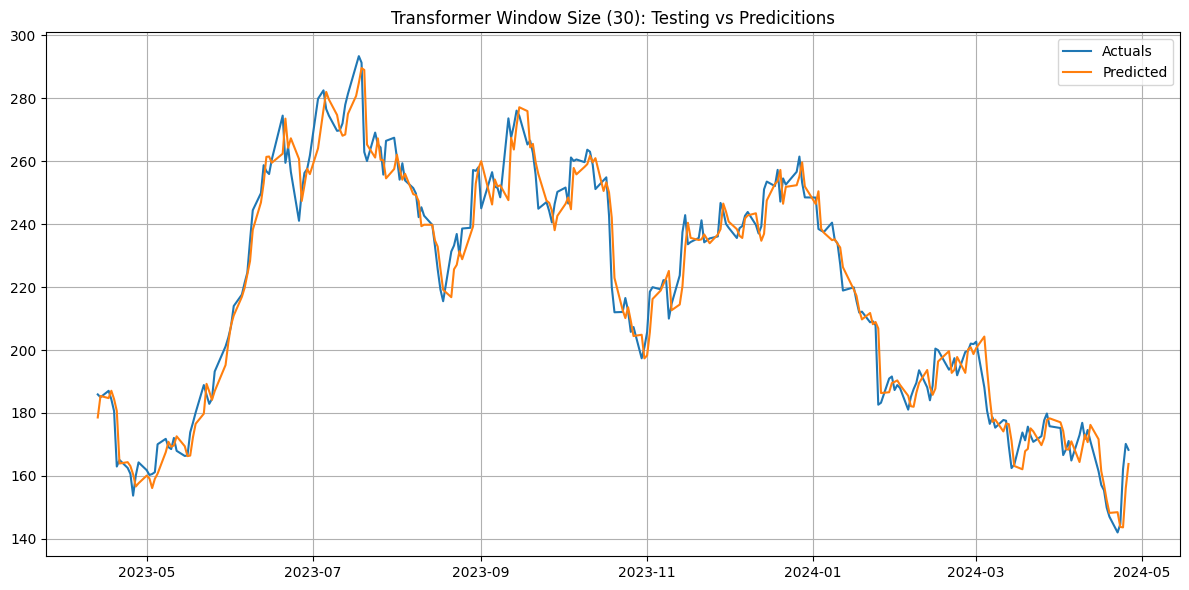

In [23]:
plt.figure(figsize=(12, 6))
#plt.plot(X_['Close'], label = 'Train')
plt.plot(test_results['Actuals'], label = 'Actuals')
plt.plot(test_results['Predicted'], label = 'Predicted')

plt.title('Transformer Window Size (30): Testing vs Predicitions')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

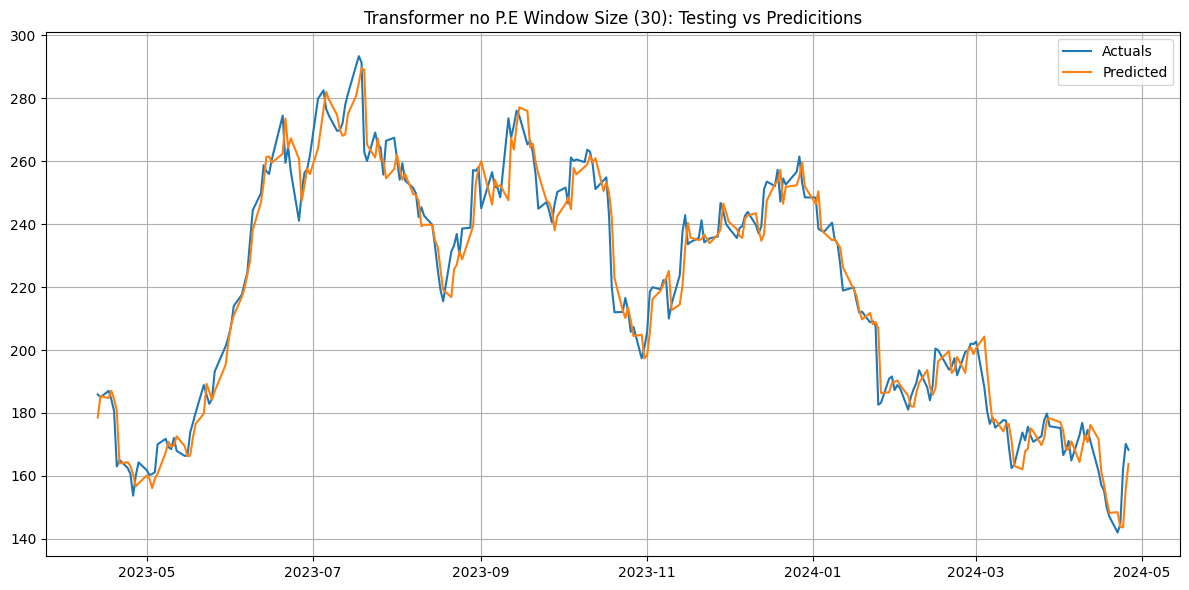

In [24]:
plt.figure(figsize=(12, 6))
#plt.plot(X_['Close'], label = 'Train')
plt.plot(test_results['Actuals'], label = 'Actuals')
plt.plot(test_results['Predicted'], label = 'Predicted')

plt.title('Transformer no P.E Window Size (30): Testing vs Predicitions')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()